In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from datetime import datetime, timedelta
from control.modules.thrusters import (
    ThrustersAlarms,
    ThrustersControl,
    ThrustersParameters,
)
from input_output.base import Stamped, StampedDf
from input_output.definitions.simulation import (
    Boundary,
    Pcs,
    TemperatureBoundary,
    Thruster,
)
from input_output.modules.thrusters import (
    ThrustersControlValues,
    ThrustersSensorValues,
    ThrustersSimulationInputs,
    ThrustersSimulationOutputs,
)
from orchestration.simulator import Simulator, SimulatorModel
from simulation.models.fmu_paths import thrusters_path
import polars as pl

start_time = datetime.fromtimestamp(0)
duration = timedelta(minutes=49)
time_index = pl.datetime_range(
    start_time, start_time + duration, interval="1m", time_unit="us", eager=True
)

thrusters_pcs = StampedDf.stamp(
    pl.DataFrame(
        {
            "time": time_index,
            "value": 2 * ["off"] + 38 * ["propulsion"] + 10 * ["maneuvering"],
        },
    )
)

supply_temperature = StampedDf.stamp(
    pl.DataFrame({"time": time_index, "value": 20 * [60.0] + 30 * [85.0]})
)
fwd_thruster_active = StampedDf.stamp(
    pl.DataFrame({
        "time": time_index,
        "value": 2 * ["False"] + 28 * ["True"] + 20 * ["False"],
    })
)
fwd_thruster_heat = StampedDf.stamp(
    pl.DataFrame({"time": time_index, "value": 2 * [0.0] + 28 * [4300.0] + 20 * [0]})
)

aft_thruster_heat = StampedDf.stamp(
    pl.DataFrame({"time": time_index, "value": 2 * [0.0] + 48 * [9000.0]})
)

simulation_inputs = ThrustersSimulationInputs(
    thrusters_aft=Thruster(heat_flow=aft_thruster_heat, active=Stamped.stamp(True)),
    thrusters_fwd=Thruster(heat_flow=fwd_thruster_heat, active=fwd_thruster_active),
    thrusters_seawater_supply=Boundary(
        temperature=Stamped.stamp(32.0), flow=Stamped.stamp(64.0)
    ),
    thrusters_module_supply=TemperatureBoundary(temperature=supply_temperature),
    thrusters_pcs=Pcs(mode=thrusters_pcs),
)

control = ThrustersControl(
    ThrustersParameters(
        cooling_mix_setpoint=40,
        recovery_thruster_flow=10,
        cooling_thruster_flow=20,
        max_inlet_temp=70,
        recovery_mix_setpoint=60,
    )
)

thrusters_model = SimulatorModel(
    fmu_path=thrusters_path,
    sensor_values_cls=ThrustersSensorValues,
    control_values_cls=ThrustersControlValues,
    simulation_outputs_cls=ThrustersSimulationOutputs,
    simulation_inputs=simulation_inputs,
    control=control,
    alarms=ThrustersAlarms(),
    tick_duration=timedelta(seconds=1),
    start_time=start_time,
)

simulation = Simulator(thrusters_model)

result = await simulation.run(int(duration.total_seconds()))

[WARNING] Warning: The following was detected at time: 5.680918952062221E-28
[WARNING]   Thruster_Module_FMU.thrusterModule.flowJoin_mixing_return: Flow splitRatio is negative and far below 0. But it must be between 0 and 1. (is -5.57274)
  Failed condition: thrusterModule.flowJoin_mixing_return.splitRatio >= -0.001

[WARNING] Warning: The following was detected at time: 1.006823988306001E-23
[WARNING]   Thruster_Module_FMU.thrusterModule.flowJoin_thruster_out: Flow splitRatio is negative and far below 0. But it must be between 0 and 1. (is -3.30264e+15)
  Failed condition: thrusterModule.flowJoin_thruster_out.splitRatio >= -0.001

[WARNING] Warning: The following was detected at time: 1.253215402201755E-07
[WARNING]   Thruster_Module_FMU.thrusterModule.flowJoin_thruster_out: Flow splitRatio is far above 1. But it must be between 0 and 1. (is 1.001)
  Failed condition: thrusterModule.flowJoin_thruster_out.splitRatio <= 1.001

[WARNING] Warning: The following was detected at time: 1.787

/Users/alje/Repos/zero-thrs-control/src/orchestration/collector.py:25: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  self._data.vstack(pl.DataFrame({**values, 'time': time, 'control_mode': control_mode}, schema_overrides = self._schema, strict = False), in_place=True)


[WARNING] Warning: The following was detected at time: 795.359647935201
[WARNING]   Thruster_Module_FMU.thrusterModule.flowJoin_thruster_out: Flow splitRatio is negative and far below 0. But it must be between 0 and 1. (is -0.001)
  Failed condition: thrusterModule.flowJoin_thruster_out.splitRatio >= -0.001

[WARNING] Warning: The following was detected at time: 795.3596568769059
[WARNING]   Thruster_Module_FMU.thrusterModule.flowJoin_seawaterCooler: Flow splitRatio is negative and far below 0. But it must be between 0 and 1. (is -0.001)
  Failed condition: thrusterModule.flowJoin_seawaterCooler.splitRatio >= -0.001



/Users/alje/Repos/zero-thrs-control/src/orchestration/cycler.py:27: UserWarning: Alarms detected: [Alarm(code='A004', severity=<Severity.ALARM: 'alarm'>)]
  warnings.warn(f"Alarms detected: {alarms}")


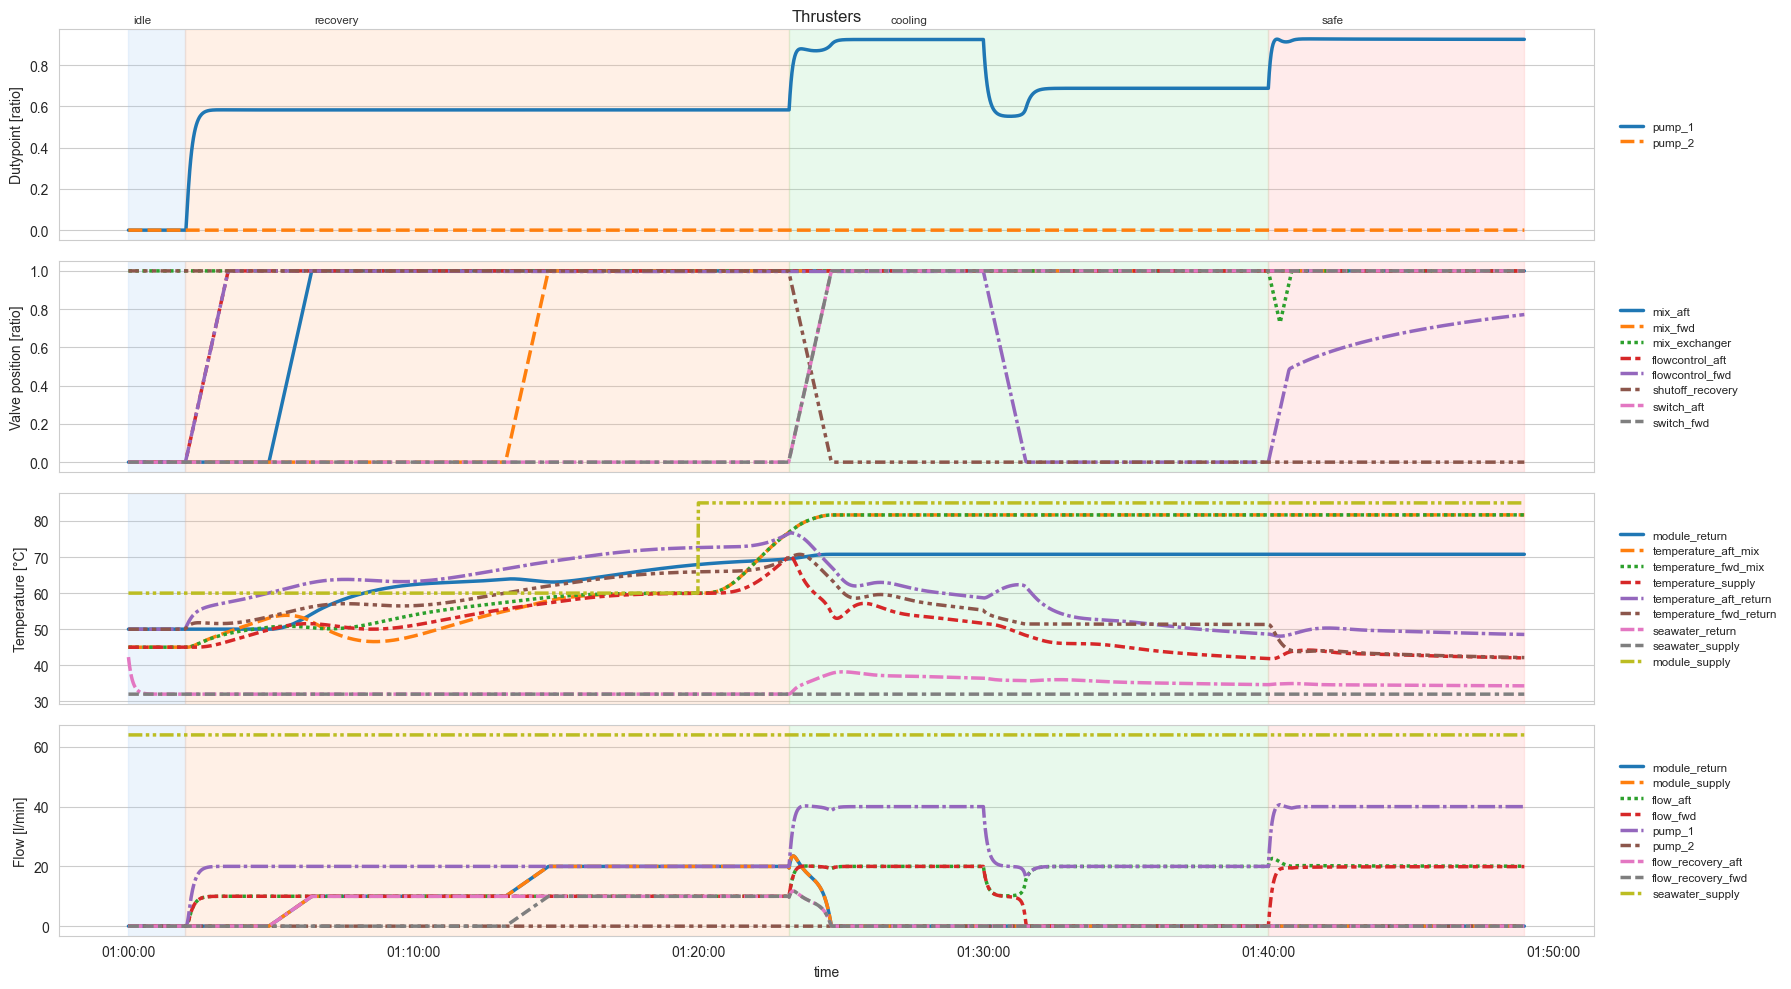

In [8]:
from analysis.analysis_utils import plot_result

plot_result(result, "plots/thrusters.png");

In [38]:
from transitions.extensions import GraphMachine
control = ThrustersControl(
    ThrustersParameters(
        cooling_mix_setpoint=40,
        recovery_thruster_flow=10,
        cooling_thruster_flow=20,
        max_inlet_temp=70,
        recovery_mix_setpoint=60,
    )
)
# without further arguments pygraphviz will be used
machine = GraphMachine(model=control, states = control.states, transitions=control.transitions, graph_engine = 'pygraphviz', initial = 'idle', show_conditions=True, show_state_attributes=True)

# draw the whole graph ...
control.get_graph().draw("thrusters_state_diagram.png", prog="dot")


In [ ]:
import polars as pl

from analysis.analysis_utils import compute_heat



df = result.group_by_dynamic("time", every="1m").agg([
    pl.col("*").mean()
])

# Add new columns for heat calculations
heat = pl.DataFrame({"thrusters_heat_recovered":
    compute_heat(
        df["thrusters_module_return__temperature__C"],
        df["thrusters_module_supply__temperature__C"],
        df["thrusters_module_supply__flow__l_min"]
    ),
    "thrusters_heat_dumped" :compute_heat(
        df["thrusters_seawater_return__temperature__C"],
        df["thrusters_seawater_supply__temperature__C"],
        df["thrusters_seawater_supply__flow__l_min"]
    ),
    "thrusters_aft_heat":compute_heat(
        df["thrusters_temperature_aft_return__temperature__C"],
        df["thrusters_temperature_supply__temperature__C"],
        df["thrusters_flow_aft__flow__l_min"]
    ),
    "thrusters_fwd_heat":compute_heat(
        df["thrusters_temperature_fwd_return__temperature__C"],
        df["thrusters_temperature_supply__temperature__C"],
        df["thrusters_flow_fwd__flow__l_min"]
    )
})

heat_df = heat.with_columns(df['time']).to_pandas().set_index('time')
temp_df = df.select([col for col in df.columns if "__temperature__" in col or col=="time"]).to_pandas().set_index('time')
flow_df = df.select([col for col in df.columns if "__flow__" in col or col=="time"]).to_pandas().set_index('time')
valve_df = df.select([col for col in df.columns if ("__position_rel__" in col and 'mix' in col) or col=="time"]).to_pandas().set_index('time')

(<Figure size 1000x800 with 4 Axes>,
 array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
        <Axes: xlabel='time'>, <Axes: xlabel='time'>], dtype=object))

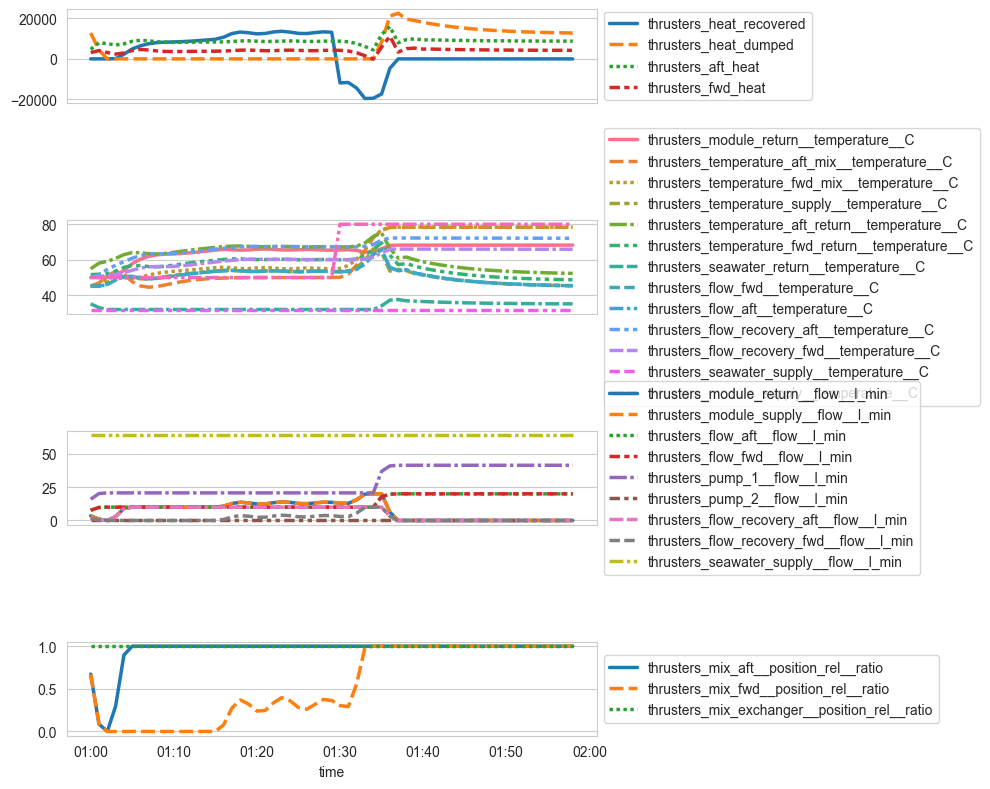

In [ ]:
from analysis.analysis_utils import plot_frames


frames = [heat_df, temp_df, flow_df, valve_df]

plot_frames(frames, "plots/thrusters_heat.png")